In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import sys
import os

# modify the path below accordingly
PATH = "/content/drive/MyDrive/HGR/gesture_face_features"

sys.path.append(os.path.join(PATH, "code"))

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# importing .py files from /code
from utils import *

In [5]:
import os
import re
import pickle

import numpy as np
# import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import requests

from PIL import Image
from io import BytesIO

In [6]:
# import umap.umap_ as umap
# from sklearn.manifold import TSNE
# from sklearn.cluster import KMeans
# from sklearn.model_selection import ParameterGrid

from tensorflow.keras.models import Model

In [7]:
# Main configurations

available_letters = ["A", "H", "L", "N", "O", "P", "R"]

# Face images are not added yet
participants = {
  0: list(range(2914, 2951)),
  1: list(range(2871, 2904)),
  2: list(range(2323, 2356)),
  3: list(range(2285, 2314)),
  4: list(range(1646, 1675)),
  5: list(range(1503 , 1544)),
}

test_imgs = [2919, 2871, 2325, 2287, 1646, 1539]

available_models = [
  "VGG19",
  "ResNet50",
  "InceptionV3",
  "EfficientNetB0",
  "EfficientNetB1",
  "EfficientNetB6",
  #"EfficientNetB7",
]

similarity_scores = {
  ('R', 'N'): 0.8,
  ('R', 'O'): 0.6,
  ('N', 'O'): 0.6,
  ('H', 'P'): 0.8,
  ('P', 'L'): 0.8,
  ('H', 'L'): 0.6,
}
for letter in 'AHLNPRO':
  # Identical letters get maximal score
  similarity_scores[(letter, letter)] = 1.0

In [8]:
# Secondary configurations
letter = available_letters[:]
img_type = 'sign'
img_count = None
partic_num = 0
participant = participants[partic_num]

# Model configurations
model_name = available_models[2]
input_dim = (299, 299) # default
model = None
include_top = True
debug = False
random_state = 42
n_clusters = len(available_letters)

In [9]:
# # loading all images
def load_all_imgs():
  img_numbers_list = []
  for i in range(len(participants)):
    img_numbers_list.extend(participants[i])

  folder_paths, img_paths, labels, img_numbers = get_paths(os.path.join(PATH, 'samples', img_type), letter, img_count=img_count, img_numbers_list=img_numbers_list)
  imgs = load_imgs(img_paths)

  return imgs, labels, img_numbers

In [10]:
imgs, labels, img_numbers = load_all_imgs()

201 images loaded


In [11]:
imgs_resized = [img.resize(input_dim,  Image.Resampling.LANCZOS) for img in imgs]
imgs_array = np.array([np.array(img) / 255.0 for img in imgs_resized])

In [25]:
from sklearn.preprocessing import LabelBinarizer

label_encoder = LabelBinarizer()
labels_encoded = label_encoder.fit_transform(labels)  # Convert labels to one-hot encoding

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    imgs_array, labels_encoded, test_size=0.2, random_state=42
)

In [14]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [15]:
model = InceptionV3(weights='imagenet', include_top=False)
model.trainable = False

87910968/87910968 [==============================] - 0s 0us/step


In [16]:
model = Sequential([
    model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 output classes
])

In [17]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=8,
    verbose=1
)

Epoch 1/20
20/20 [==============================] - 51s 2s/step - loss: 2.1885 - accuracy: 0.1063 - val_loss: 2.1136 - val_accuracy: 0.0976
Epoch 2/20
20/20 [==============================] - 44s 2s/step - loss: 2.0780 - accuracy: 0.1312 - val_loss: 2.0366 - val_accuracy: 0.1220
Epoch 3/20
20/20 [==============================] - 43s 2s/step - loss: 1.9366 - accuracy: 0.1813 - val_loss: 2.0244 - val_accuracy: 0.0976
Epoch 4/20
20/20 [==============================] - 43s 2s/step - loss: 1.9395 - accuracy: 0.1562 - val_loss: 2.0271 - val_accuracy: 0.0976
Epoch 5/20
20/20 [==============================] - 43s 2s/step - loss: 1.7525 - accuracy: 0.3500 - val_loss: 1.9701 - val_accuracy: 0.1463
Epoch 6/20
20/20 [==============================] - 43s 2s/step - loss: 1.8018 - accuracy: 0.2812 - val_loss: 1.9817 - val_accuracy: 0.1951
Epoch 7/20
20/20 [==============================] - 43s 2s/step - loss: 1.7247 - accuracy: 0.3625 - val_loss: 2.0011 - val_accuracy: 0.2195
Epoch 8/20
20/20 [==

In [19]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {test_accuracy * 100:.2f}%")

# Save the model
model.save(os.path.join(PATH, 'code', 'gesture_recognition_model.h5'))

2/2 [==============================] - 7s 2s/step - loss: 1.8446 - accuracy: 0.2927
Validation Accuracy: 29.27%


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities for each image in the validation set
predictions = model.predict(X_val)

# Get the predicted class indices
predicted_labels = np.argmax(predictions, axis=1)

# Convert true labels to class indices if they are one-hot encoded
true_labels = np.argmax(y_val, axis=1)

# Define your class names (decode from label encoder if used)
class_names = label_encoder.classes_  # Assuming you used LabelBinarizer for encoding

# Function to plot an image with its predicted and true labels
def plot_image_with_labels(image, pred_label, true_label):
    plt.imshow(image)
    plt.axis('off')
    color = "green" if pred_label == true_label else "red"
    plt.title(f"Predicted: {class_names[pred_label]}, True: {class_names[true_label]}", color=color)
    plt.show()

# Loop through validation images and plot predictions
for i in range(len(X_val)):
    image = X_val[i]  # Select the image
    image = np.squeeze(image)  # Remove unnecessary dimensions if any
    plot_image_with_labels(image, predicted_labels[i], true_labels[i])

Output hidden; open in https://colab.research.google.com to view.

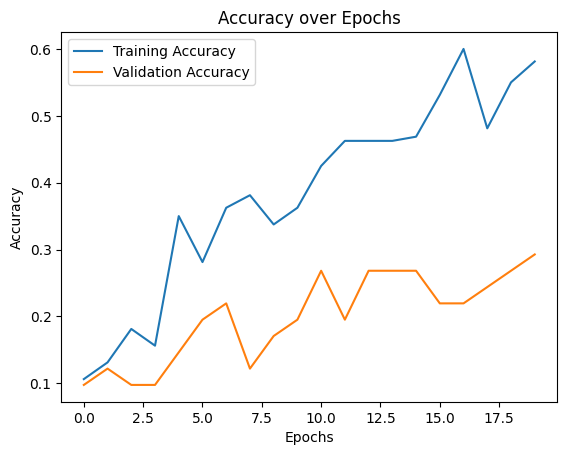

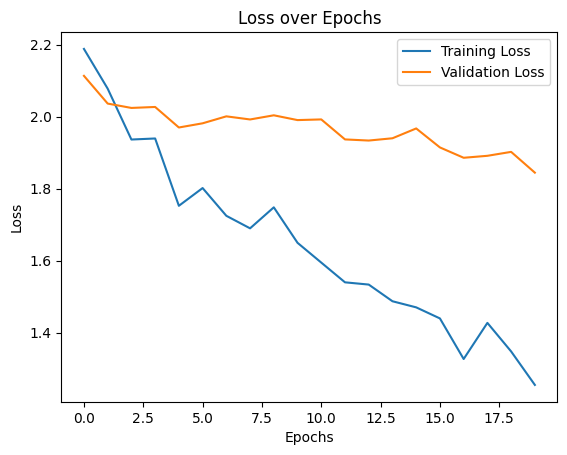

In [21]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [22]:
from tensorflow.keras.utils import to_categorical
labels_encoded = to_categorical(labels_encoded, num_classes=7)  # Adjust num_classes


In [24]:
labels_encoded[0]

array([[0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]], dtype=float32)